# Análisis de sentimientos

# Twitter US airlines

Juliana Paola Forero Larrotta

In [1]:
# Libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import read_csv
import seaborn as sns


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *

nltk.download('wordnet')

from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve 
from sklearn import metrics
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
import string

from pylab import rcParams
import os

os.chdir("C:\\Users\\Juliana Forero\\Desktop\\Ciencia de datos y Big data\\Análisis de sentimiento")
os.getcwd()

#tf.__version__

[nltk_data] Downloading package stopwords to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Juliana Forero\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'C:\\Users\\Juliana Forero\\Desktop\\Ciencia de datos y Big data\\Análisis de sentimiento'

In [2]:
# Load data

df= read_csv('Tweets.csv', sep=',')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


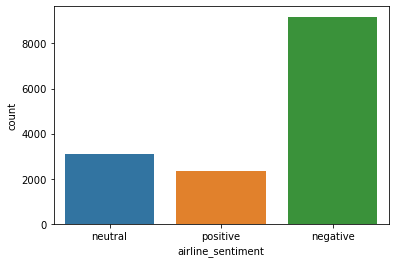

In [168]:
# visualize the target variable
g = sns.countplot(df['airline_sentiment'])
#g.set_xticklabels(['No incumplimiento','Incumplimiento'])
plt.show()

Como el total de tweets negativos supera a los tweets positivos y neutrales, para correr los modelos de clasificación las clases neutral y positivas se volverán una sola clase.

Como cada comentario ya tiene asignado un sentimiento según la variable "airline_sentiment" esta será la variable respuesta, se debe hacer la limpieza y el procesamiento de los comentarios antes de correr el modelo. 

## Preprocesamiento

In [46]:
stop_words = stopwords.words('english') 

In [47]:
def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt

In [48]:
print('Original Text : ',df['text'][2])  
print('Processed Text : ',clean_text(df['text'][2]))

Original Text :  @VirginAmerica I didn't today... Must mean I need to take another trip!
Processed Text :  didnt today must mean need take anoth trip


Se observa que luego de hacer el stemming las palabras quedan un poco cortadas, con lo cual, en mi opinión personal no se debería aplicar este procedimiento; sin embargo se proseguirá así, dado que este paso se recomienda según la teoría de NLP.

In [49]:
# se codifica la variable respuesta como 1 (positivos y neutrales) y 0 (negativos)

df['sent_encoded'] = df['airline_sentiment'].apply(lambda x:0 if x =='negative' else 1)
df['cleaned_text'] = df['text'].apply(clean_text) 

In [173]:
# Se crean los conjuntos de entrenamiento y prueba y los documentos se convierten a una matriz de conteo de tokens con 
# CountVectorizer

def train_test_data():   
    y = df['sent_encoded']   # define target and feature column
    X = df['cleaned_text']
     
    train_text, test_text, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)    # do the split
    vect = CountVectorizer(min_df=5, ngram_range=(1, 4)) # create Count vectorizer.
    X_train = vect.fit(train_text).transform(train_text) # transform text_train  into a vector 
    X_test = vect.transform(test_text) 
    feature_names = vect.get_feature_names() # to return all words used in vectorizer
  
    return X_train, X_test, y_train, y_test, feature_names

In [174]:
 X_train, X_test, y_train, y_test, feature_names = train_test_data()

In [175]:
print(X_train.shape) 
print(X_test.shape)

(11712, 3831)
(2928, 3831)


# Regresión logística: Logit

* Beneficios: Fácil de interpretar
* Limitaciones: no se comporta bien con las relaciones de tipo no lineal, es sensible a outliers, funciona mejor con variables numéricas.
* Permite calcular la probabilidad de que un cliente no pague la primera factura en este dataset.

In [176]:
model_name = 'Logistic Regression'
logreg = LogisticRegression()
trained_model_lr = logreg.fit(X_train, y_train.values.ravel())

In [177]:
print ("Trained model :: ", trained_model_lr)

Trained model ::  LogisticRegression()


Se calculan las probabilidades de predicción en el set de prueba y de entrenamiento mediante la función predict

In [178]:
prob_test  = trained_model_lr.predict_proba(X_test)
prob_train = trained_model_lr.predict_proba(X_train)

#Probability Threshold = 0.5 (default) 
pred_test  = trained_model_lr.predict(X_test)
pred_train = trained_model_lr.predict(X_train)

AUC: Área bajo la curva, métrica que calcula el performance general de un modelo de clasificación basado en el área bajo la curva de ROC

In [179]:
#Calculate AUC
auc_score = roc_auc_score(y_test, prob_test[:,1])
print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                      % auc_score)

#Calculate train and test accuracy
train_acc = accuracy_score(y_train.values.ravel(), pred_train)
test_acc  = accuracy_score(y_test.values.ravel(), pred_test)
print ("\nTrain Accuracy :: ", train_acc)
print ("\nTest Accuracy :: ", test_acc)



Model ROC-AUC score for validation sample: 0.891

Train Accuracy ::  0.9074453551912568

Test Accuracy ::  0.8138661202185792


En este caso la precisión es del 91% aproximadamente lo que es muy bueno

In [180]:
## Matriz de Confusion

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
  
  """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
      
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  print(confusion_matrix(y_test, pred_test, labels=[1,0]))

Confusion matrix, without normalization
[[ 785  273]
 [ 272 1598]]
[[ 785  273]
 [ 272 1598]]


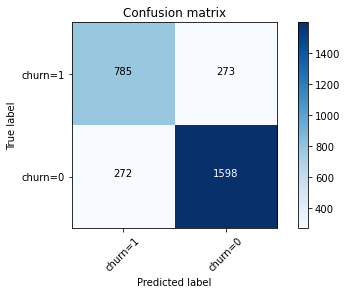

In [21]:
# Calcular la matriz de confusion
cnf_matrix = confusion_matrix(y_test.values.ravel(), pred_test, labels=[1,0])
np.set_printoptions(precision=2)

# Graficar la matriz de confusion no normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1', 'churn=0'], normalize= False, title='Confusion matrix')

* Recall: proporción de positivos actuales (TP+FN) que fueron identificados correctamente (TP)-->TP/(TP+FN)
* Precision: prop. de positivos identificados (TP+FP) que fueron correctos (TP)-->TP/(TP+FP)
* F1 score: métrica qeu combina recall y precision usando la media armónica.
* El promedio ponderado se basa en el número de instancias de cada clase, es útil en el caso desbalanceado, pero el impacto de la clase menos frecuente se omite.
* La curva precision-recall con la curva ROC puede ser usada para seleccionar un umbral de corte óptimo basado en el clasificador predictivo que sirva para el objetivo del negocio.

In [181]:
#Calculate classification model evaluation metrics like precision, recall, f1 score
report = classification_report(y_test, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(y_test, pred_test))


 Classification report (weighted average across classes) ::
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1870
           1       0.74      0.74      0.74      1058

    accuracy                           0.81      2928
   macro avg       0.80      0.80      0.80      2928
weighted avg       0.81      0.81      0.81      2928



Se observa como las métricas de evaluación del modelo como precision, recall y f1-score son 74% para la clase 1 (positivo) y 85% para la clase 0 (negativo).

# Naive Bayes

* Beneficios: simple y rápido, funciona bien con muestras pequeñas.
* Limitaciones: falla al estimar ocurrencias raras, puede que las probabilidades estimadas no sean confiables.

In [182]:
model_name        = 'Gaussian Naive Bayes'
gnb               = GaussianNB()
trained_model_gnb = gnb.fit(X_train.todense(), y_train.values.ravel())

In [183]:
prob_test  = trained_model_gnb.predict_proba(X_test.todense())
prob_train = trained_model_gnb.predict_proba(X_train.todense())

#Probability Threshold = 0.5 (default) 
pred_test  = trained_model_gnb.predict(X_test.todense())
pred_train = trained_model_gnb.predict(X_train.todense())

#Calculate AUC
auc_score = roc_auc_score(y_test, prob_test[:,1])
print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                      % auc_score)

#Calculate train and test accuracy
train_acc = accuracy_score(y_train.values.ravel(), pred_train)
test_acc  = accuracy_score(y_test.values.ravel(), pred_test)
print ("\nTrain Accuracy :: ", train_acc)
print ("\nTest Accuracy :: ", test_acc)



Model ROC-AUC score for validation sample: 0.681

Train Accuracy ::  0.7030396174863388

Test Accuracy ::  0.6133879781420765


La predicción bajo el modelo de Naive Bayes tiene una precisión del 71% aprox. en el conjunto de entrenamiento.

In [184]:
# Vector de Predicciones:

#y_hats  = trained_model_gnb.predict(xtest)
y_hats  = pd.DataFrame(prob_test)
proba = y_hats[1]
proba = pd.DataFrame(proba)
proba

,1
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
2923,1.0
2924,0.0
2925,1.0
2926,1.0


In [185]:
#Calculate classification model evaluation metrics like precision, recall, f1 score

report = classification_report(y_test, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(y_test, pred_test))


 Classification report (weighted average across classes) ::
               precision    recall  f1-score   support

           0       0.91      0.44      0.59      1870
           1       0.48      0.93      0.63      1058

    accuracy                           0.61      2928
   macro avg       0.70      0.68      0.61      2928
weighted avg       0.76      0.61      0.61      2928



Se observa como las métricas de evaluación del modelo como precision, recall y f1-score son 48%, 93% y 63%, respectivamente para la clase 1 (positivo) y 91%, 44% y 59%, respectivamente, para la clase 0 (negativo), podría decirse que el logit tiene unas métricas más altas que el Naive Bayes.

# Support Vector Machine (SVM)

In [186]:
model_name        = 'Support Vector Machine'
svm               = SVC()
trained_model_svm = svm.fit(X_train, y_train.values.ravel())



#Probability Threshold = 0.5 (default) 
pred_test  = trained_model_svm.predict(X_test)
pred_train = trained_model_svm.predict(X_train)


#Calculate AUC
auc_score = roc_auc_score(y_test, prob_test[:,1])
print ("\n\nModel ROC-AUC score for validation sample: %.3f" \
                                      % auc_score)

#Calculate train and test accuracy
train_acc = accuracy_score(y_train.values.ravel(), pred_train)
test_acc  = accuracy_score(y_test.values.ravel(), pred_test)
print ("\nTrain Accuracy :: ", train_acc)
print ("\nTest Accuracy :: ", test_acc)





Model ROC-AUC score for validation sample: 0.681

Train Accuracy ::  0.9398907103825137

Test Accuracy ::  0.8217213114754098


La predicción bajo el modelo de SVM tiene una precisión del 94% aprox. en el conjunto de entrenamiento superando a Naive Bayes y al logit.

In [187]:
#Calculate classification model evaluation metrics like precision, recall, f1 score

report = classification_report(y_test, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(y_test,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(y_test, pred_test))


 Classification report (weighted average across classes) ::
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1870
           1       0.78      0.71      0.74      1058

    accuracy                           0.82      2928
   macro avg       0.81      0.80      0.80      2928
weighted avg       0.82      0.82      0.82      2928



Se observa como las métricas de evaluación del modelo como precision, recall y f1-score son 78%, 71% y 74%, respectivamente para la clase 1 (positivo) y 84%, 88% y 86%, respectivamente, para la clase 0 (negativo), podría decirse que el SVM tiene unas métricas más altas que el Naive Bayes y Logit, en general.

# Red neuronal

In [1]:
# Librerias

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *

nltk.download('wordnet')

from collections import Counter


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve 
from sklearn import metrics
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
import string

from pylab import rcParams
import os

os.chdir("C:\\Users\\Juliana Forero\\Desktop\\Ciencia de datos y Big data\\Análisis de sentimiento")
os.getcwd()


[nltk_data] Downloading package stopwords to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Juliana Forero\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'C:\\Users\\Juliana Forero\\Desktop\\Ciencia de datos y Big data\\Análisis de sentimiento'

In [2]:
from __future__ import unicode_literals
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras. metrics import FalseNegatives, FalsePositives, TrueNegatives
from tensorflow.keras. metrics import TruePositives, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [3]:
df= read_csv('Tweets.csv', sep=',')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.shape

(14640, 15)

In [3]:
# se codifica como 1 y 0 la variable respuesta: sentimiento codificado

df['sent_encoded'] = df['airline_sentiment'].apply(lambda x:0 if x =='negative' else 1)

## Pre-procesamiento y limpieza de textos

In [6]:
stop_words = stopwords.words('english') 

In [4]:
def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    txt = re.sub(r"(@\S+)", "", txt)  # remove hashtags
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    txt = ' '.join([word for word in txt.split(" ") if word not in stop_words ]) #  remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt

In [7]:
print('Original Text : ',df['text'][2])  
print('Processed Text : ',clean_text(df['text'][2]))

Original Text :  @VirginAmerica I didn't today... Must mean I need to take another trip!
Processed Text :  didnt today must mean need take another trip


In [8]:
df['cleaned_text'] = df['text'].apply(clean_text) 

### A continuación queda el dataset con la columna de textos originales y los textos limpios, además con la variable de sentimiento codificada

In [9]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sent_encoded,cleaned_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1,said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,plus youve added commercials experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1,didnt today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0,really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,really big bad thing


In [240]:
df.shape

(14640, 17)

In [241]:
type(df)

pandas.core.frame.DataFrame

In [242]:
#Se crean los conjuntos de entrenamiento y prueba y los documentos se convierten a una matriz de conteo de tokens con 
#CountVectorizer

def train_test_data():   
    y = df['sent_encoded']   # define target and feature column
    X = df['cleaned_text']
     
    train_text, test_text, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)    # do the split
    vect = CountVectorizer(min_df=5, ngram_range=(1, 4)) # create Count vectorizer.
    X_train = vect.fit(train_text).transform(train_text) # transform text_train  into a vector 
    X_test = vect.transform(test_text) 
    feature_names = vect.get_feature_names() # to return all words used in vectorizer
  
    return X_train, X_test, y_train, y_test, feature_names

In [243]:
X_train, X_test, y_train, y_test, feature_names = train_test_data()

In [247]:
# Se vuelve a hacer la limpieza de los textos pero se guarda en un objeto que servirá para procesar y usar en el modelo de red neuronal

cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in df["text"]:
    text = re.sub(r'http\S+', '', text)
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    text = [word for word in text if word not in swords]
    text = " ".join(text)
    cleanedData.append(text)

In [248]:
cleanedData[1]

'virginamerica plus added commercial experience tacky'

In [249]:
# Aquí los textos se vuelven una secuencia de números que se usarán para poder ajustar el modelo

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleanedData)
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary size:{}'.format(vocab_size))
max_len = 30
print('max length of input:{}'.format(max_len))
sequence = tokenizer.texts_to_sequences(cleanedData)

x = pad_sequences(sequence, max_len, padding='post')
print('example x:{}'.format(x[4]))

vocabulary size:12838
max length of input:30
example x:[ 34  71 364 129 189   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [250]:
# Se define una función para predecir, tal que si se tiene [0][0] == 1 la predicción será positiva y de lo contrario es negativa

def check(predict):
    if(predict[0][0]) == 1.:
        print("Positive")
    else:
        print("Negative")

### Se entrena el modelo de red neuronal de tipo secuencial con 10 iteraciones y función de activación de salida tipo sigmoide

In [251]:
from tensorflow.keras import layers, Sequential

max_features = 1000
embedding_dim = 16

BATCH_SIZE = 64
EPOCHS = 20
embedding_dim=16
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='sigmoid')
    
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 16)            205408    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 512)           420864    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

### Se compila el modelo con una función de pérdida de tipo etropía cruzada categórica dispersa, con optimizador Adam, usando un tamaño de grupos o lotes de 64

In [252]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, df["sent_encoded"], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/20
206/206 [==============================] - 52s 227ms/step - loss: 0.5993 - accuracy: 0.6650 - val_loss: 0.3467 - val_accuracy: 0.8490
Epoch 2/20
206/206 [==============================] - 43s 207ms/step - loss: 0.3141 - accuracy: 0.8726 - val_loss: 0.3450 - val_accuracy: 0.8367
Epoch 3/20
206/206 [==============================] - 37s 179ms/step - loss: 0.2312 - accuracy: 0.9086 - val_loss: 0.4208 - val_accuracy: 0.8135
Epoch 4/20
206/206 [==============================] - 33s 162ms/step - loss: 0.1703 - accuracy: 0.9376 - val_loss: 0.4237 - val_accuracy: 0.8436
Epoch 5/20
206/206 [==============================] - 33s 163ms/step - loss: 0.1355 - accuracy: 0.9501 - val_loss: 0.4791 - val_accuracy: 0.8238
Epoch 6/20
206/206 [==============================] - 34s 165ms/step - loss: 0.1063 - accuracy: 0.9616 - val_loss: 0.5864 - val_accuracy: 0.8169
Epoch 7/20
206/206 [==============================] - 34s 166ms/step - loss: 0.0921 - accuracy: 0.9647 - val_loss: 0.6335 - val_ac

In [253]:
check1 = ["This airline is the best in the US"]
check1 = tokenizer.texts_to_sequences(check1)
check1 = pad_sequences(check1, maxlen=max_len, padding='post')

check2 =["This airline is a shit"]
check2 = tokenizer.texts_to_sequences(check2)
check2 = pad_sequences(check2, maxlen=max_len, padding='post')

In [254]:
result = model.predict(check1)
result2 = model.predict(check2)

In [255]:
print(check(result.round())+check(result2.round()))

Positive
Positive


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

A partir de la predicción de los 2 comentarios anteriores se puede inferir que el modelo predice bien la clase positiva, pero la clase negativa no la está prediciendo bien, habría que entrar a revisar en donde está el error, tal vez la función que predice y la cual llamamos "check" no está bien definida.

O el problema está en que no se dividió de antemano el dataset en conjuntos de entrenamiento y validación.

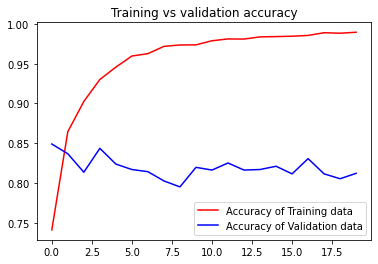

<Figure size 432x288 with 0 Axes>

In [256]:
import matplotlib.pyplot as plt
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


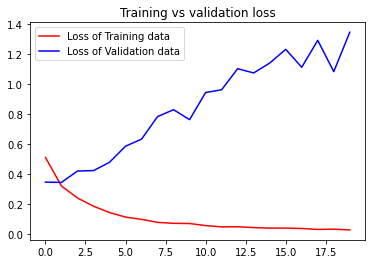

<Figure size 432x288 with 0 Axes>

In [257]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Se observa que el modelo no tiene un buen ajuste

# Se propone otra red neuronal:

In [12]:
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import gensim
from gensim.parsing.preprocessing import STOPWORDS

In [10]:
# Se crea los vectores objetivo X con los tweet limpios y y con los sentimientos codificados

X=df.cleaned_text
y=df.sent_encoded

In [13]:
# Se tokenizan los tweets y se vuelven secuencias de números

max_len = 500
tok = Tokenizer(num_words=2000)
vocab_size = len(tok.word_index) + 1
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [14]:
sequences_matrix.shape

(14640, 500)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [16]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [17]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           100000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [19]:
history = model.fit(X_train,Y_train, epochs=6, batch_size=64, validation_split=0.1, verbose=2)

Epoch 1/6
145/145 - 50s - loss: 0.5003 - accuracy: 0.7556 - val_loss: 0.3999 - val_accuracy: 0.8234
Epoch 2/6
145/145 - 49s - loss: 0.3453 - accuracy: 0.8523 - val_loss: 0.3904 - val_accuracy: 0.8341
Epoch 3/6
145/145 - 49s - loss: 0.3035 - accuracy: 0.8747 - val_loss: 0.3954 - val_accuracy: 0.8185
Epoch 4/6
145/145 - 50s - loss: 0.2809 - accuracy: 0.8872 - val_loss: 0.4080 - val_accuracy: 0.8117
Epoch 5/6
145/145 - 50s - loss: 0.2566 - accuracy: 0.8981 - val_loss: 0.4433 - val_accuracy: 0.8049
Epoch 6/6
145/145 - 50s - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.5158 - val_accuracy: 0.7980


In [20]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

138/138 [==============================] - 9s 66ms/step - loss: 0.4920 - accuracy: 0.8051


In [21]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.81


La precisión del modelo es bastante alta, del 81%

In [22]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[2312  395]
 [ 461 1224]]




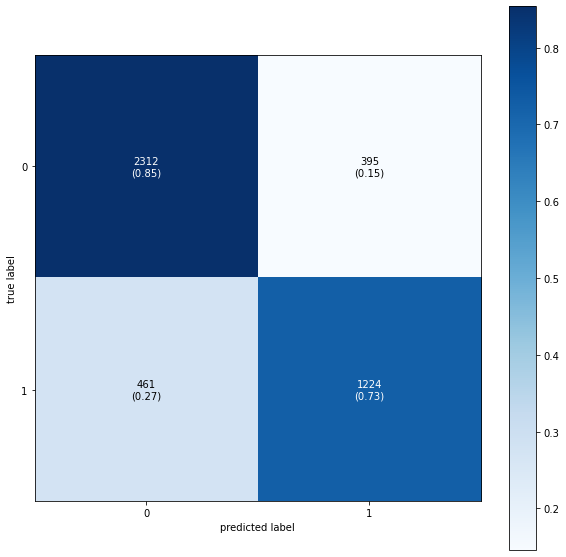

In [23]:
from mlxtend.plotting import plot_confusion_matrix

print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Conclusiones

* El segundo modelo de red neuronal clasifica mejor que el primer modelo propuesto.
* Este segundo modelo de red neuronal y el de Support Vector Machine son los que tienen un accuracy más alto.

# Sentiment 140

In [1]:
import sys
sys.modules[__name__].__dict__.clear()

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from pandas import read_csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import gensim
from gensim.parsing.preprocessing import STOPWORDS

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [43]:
data=pd.read_csv("C:/Users/Juliana Forero/Desktop/Ciencia de datos y Big data/Análisis de sentimiento/training.1600000.processed.noemoticon.csv"
                  ,encoding='latin', 
                   names = ['sentiment','id','date','query','user','tweet'])
data

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


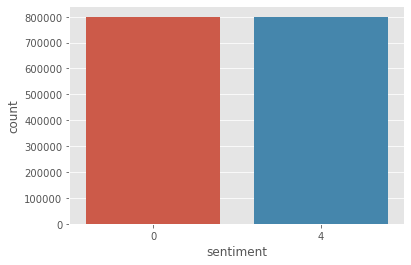

In [44]:
# visualize the target variable
g = sns.countplot(data['sentiment'])
#g.set_xticklabels(['No incumplimiento','Incumplimiento'])
plt.show()

Los tweets con sentiment igual a 4 se recodificaran con 1=positivo y los tweets con sentiment igual a 0 se recodificaran 0=negativo.

In [45]:
# recodificación

data=data[['tweet','sentiment']]
data['sentiment'][data['sentiment']==4]=1
data

,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [46]:
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

### Debido a que se tiene un conjunto de datos muy grande, con 1.600.000 registros, se debe tomar una muestra para poder correr la red neuronal y que la cantidad de parámetros no sea demasiado grande, es así como se toma una muestra de 20000 tweets por cada una de las 2 clases:

In [47]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [48]:
data = pd.concat([data_pos, data_neg])

In [49]:
data.shape

(40000, 2)

In [50]:
data.tail()

,tweet,sentiment
19995,"Not much time off this weekend, work trip to M...",0
19996,One more day of holidays,0
19997,feeling so down right now .. i hate you DAMN H...,0
19998,"geez,i hv to READ the whole book of personalit...",0
19999,I threw my sign at donnie and he bent over to ...,0


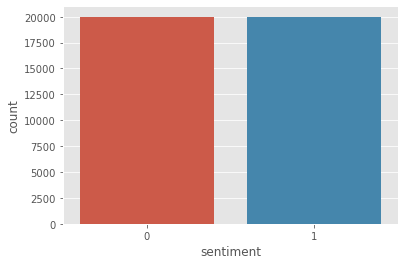

In [51]:
# visualize the target variable
g = sns.countplot(data['sentiment'])
#g.set_xticklabels(['No incumplimiento','Incumplimiento'])
plt.show()

Se observa que al tomar la muestra se conservan las proporciones de las 2 clases.

In [52]:
stopwords_list = stopwords.words('english')

## Pre-procesamiento y análisis superficial

In [53]:
# Se quitan los stopwords

STOPWORDS = set(stopwords_list)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['tweet'] = data['tweet'].apply(lambda text: cleaning_stopwords(text))
data['tweet'].head()

800000              I LOVE @Health4UandPets u guys r best!!
800001    im meeting one besties tonight! Cant wait!! - ...
800002    @DaRealSunisaKim Thanks Twitter add, Sunisa! I...
800003    Being sick really cheap hurts much eat real fo...
800004                      @LovesBrooklyn2 effect everyone
Name: tweet, dtype: object

In [54]:
# Se quitan los signos de puntuación

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [55]:
data['tweet']= data['tweet'].apply(lambda x: cleaning_punctuations(x))
data['tweet'].tail()

19995    Not much time weekend work trip Malmï¿½ FriSat...
19996                                     One day holidays
19997                     feeling right  hate DAMN HUMPREY
19998    geezi hv READ whole book personality types emb...
19999    I threw sign donnie bent get thingee made sad ...
Name: tweet, dtype: object

In [56]:
# Se remueven hashtags

def hashtags(data):
    return re.sub('@[^\s]+', ' ', data)

In [57]:
data['tweet']= data['tweet'].apply(lambda x: hashtags(x))
data['tweet'].tail()

19995    Not much time weekend work trip Malmï¿½ FriSat...
19996                                     One day holidays
19997                     feeling right  hate DAMN HUMPREY
19998    geezi hv READ whole book personality types emb...
19999    I threw sign donnie bent get thingee made sad ...
Name: tweet, dtype: object

In [58]:
# Se remueven URLs

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [59]:
data['tweet'] = data['tweet'].apply(lambda x: cleaning_URLs(x))
data['tweet'].tail()

19995    Not much time weekend work trip Malmï¿½ FriSat...
19996                                     One day holidays
19997                     feeling right  hate DAMN HUMPREY
19998    geezi hv READ whole book personality types emb...
19999    I threw sign donnie bent get thingee made sad ...
Name: tweet, dtype: object

In [60]:
# Se remueven números

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [61]:
data['tweet'] = data['tweet'].apply(lambda x: cleaning_numbers(x))
data['tweet'].tail()

19995    Not much time weekend work trip Malmï¿½ FriSat...
19996                                     One day holidays
19997                     feeling right  hate DAMN HUMPREY
19998    geezi hv READ whole book personality types emb...
19999    I threw sign donnie bent get thingee made sad ...
Name: tweet, dtype: object

In [62]:
# Se tokenizan los textos

tokenizer = RegexpTokenizer(r'\w+')
data['tweet'] = data['tweet'].apply(tokenizer.tokenize)

In [63]:
data['tweet'].head()

800000          [I, LOVE, HealthUandPets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, Cant, wai...
800002    [DaRealSunisaKim, Thanks, Twitter, add, Sunisa...
800003    [Being, sick, really, cheap, hurts, much, eat,...
800004                    [LovesBrooklyn, effect, everyone]
Name: tweet, dtype: object

In [64]:
# Lematización de textos

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['tweet'] = data['tweet'].apply(lambda x: lemmatizer_on_text(x))

In [65]:
data['tweet'].head()

800000          [I, LOVE, HealthUandPets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, Cant, wai...
800002    [DaRealSunisaKim, Thanks, Twitter, add, Sunisa...
800003    [Being, sick, really, cheap, hurts, much, eat,...
800004                    [LovesBrooklyn, effect, everyone]
Name: tweet, dtype: object

In [66]:
# Se crea los vectores objetivo X con los tweet limpios y y con los sentimientos codificados

X=data.tweet
y=data.sentiment

In [67]:
# Se tokenizan los tweets y se vuelven secuencias de números

max_len = 500
tok = Tokenizer(num_words=2000)
vocab_size = len(tok.word_index) + 1
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [68]:
sequences_matrix.shape

(40000, 500)

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [70]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [71]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [72]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [73]:
history = model.fit(X_train,Y_train, epochs=6, batch_size=64, validation_split=0.1, verbose=2)

Epoch 1/6
394/394 - 129s - loss: 0.5721 - accuracy: 0.6931 - val_loss: 0.5300 - val_accuracy: 0.7236
Epoch 2/6
394/394 - 112s - loss: 0.4957 - accuracy: 0.7608 - val_loss: 0.5247 - val_accuracy: 0.7318
Epoch 3/6
394/394 - 112s - loss: 0.5212 - accuracy: 0.7438 - val_loss: 0.5320 - val_accuracy: 0.7264
Epoch 4/6
394/394 - 113s - loss: 0.4791 - accuracy: 0.7673 - val_loss: 0.5379 - val_accuracy: 0.7236
Epoch 5/6
394/394 - 115s - loss: 0.4610 - accuracy: 0.7777 - val_loss: 0.5465 - val_accuracy: 0.7243
Epoch 6/6
394/394 - 135s - loss: 0.4462 - accuracy: 0.7826 - val_loss: 0.5687 - val_accuracy: 0.7221


In [74]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 25s 64ms/step - loss: 0.5509 - accuracy: 0.7402


In [75]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


La precisión del modelo no es tan alta.

In [76]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[4309 1700]
 [1417 4574]]




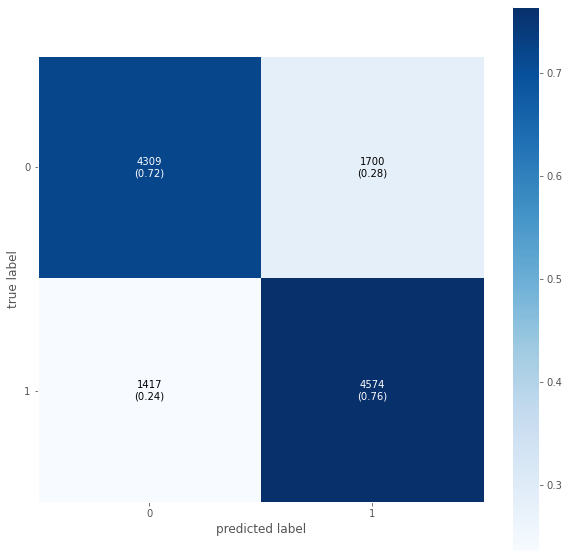

In [77]:
from mlxtend.plotting import plot_confusion_matrix

print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

La clasificación es buena pero no es la mejor.

# Análisis de texto superficial completo con las palabras positivas

Haga un análisis de texto superficial completo con las palabras positivas y otro con las negativas por separado. Use fatstext y haga gráficas ilustrativas con TSNE. 

In [1]:
# Librerias

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *

nltk.download('wordnet')

import numpy as np 
import pandas as pd 
import seaborn as sns 
from pandas import read_csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Juliana Forero\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data=pd.read_csv("C:/Users/Juliana Forero/OneDrive - Universidad Nacional de Colombia/Escritorio/Ciencia de datos y Big data/Análisis de sentimiento/training.1600000.processed.noemoticon.csv"
                  ,encoding='latin', 
                   names = ['sentiment','id','date','query','user','tweet'])

# recodificación

data=data[['tweet','sentiment']]
data['sentiment'][data['sentiment']==4]=1
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

In [6]:
# Se omiten los tweets clasificados como neutrales
#data_pos.head(10)
#datapos = data[data['sentiment'] != 0]
data_pos.head(10)

,tweet,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1
800005,@ProductOfFear You can tell him that I just bu...,1
800006,@r_keith_hill Thans for your response. Ihad al...,1
800007,"@KeepinUpWKris I am so jealous, hope you had a...",1
800008,"@tommcfly ah, congrats mr fletcher for finally...",1
800009,@e4VoIP I RESPONDED Stupid cat is helping me ...,1


In [3]:
data_pos.shape

(800000, 2)

In [25]:
from string import punctuation
import re
import nltk
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

data_2 = data_pos[['tweet', 'sentiment']]

def normalize_document(doc):
    # remove special characters: 
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # transform to lower case
    doc = doc.lower()
    # remove \whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
# crea una función vectorizada para que actué sobre múltiples textos
normalize_corpus = np.vectorize(normalize_document)

remove_terms = list(punctuation + '0123456789')
norm_df = [[word.lower() for word in text.split() if word not in remove_terms] for text in data_2.tweet]
norm_df = [[re.sub(r'@\w+', '', word) for word in text if word not in remove_terms] for text in norm_df]    #remove mentions
norm_df = [[re.sub(r'http\S+', '', word) for word in text if word not in remove_terms] for text in norm_df] #remove links
norm_df = [' '.join(tok_sent) for tok_sent in norm_df]
norm_df = filter(None, normalize_corpus(norm_df))
norm_df = [tok_sent for tok_sent in norm_df if len(tok_sent.split()) > 2]

print(norm_df[20])

[nltk_data] Downloading package stopwords to C:\Users\Juliana
[nltk_data]     Forero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


walking put deposit tomorrow


# FastText

Permite encontrar similitudes entre los textos.

In [44]:
from gensim.models import FastText

tokenized_corpus = [wpt.tokenize(document) for document in norm_df]

# Set values for various parameters
size = 100    # Word vector dimensionality  (embedding dim)
window = 30   # Context window size                                                                                    
min_count = 1   # Minimum word count                        
#sample = 10   # Downsample setting for frequent words

#ft_model = FastText(tokenized_corpus, size, window, min_count)


ft_model = gensim.models.Word2Vec(
            tokenized_corpus,
            vector_size=200)

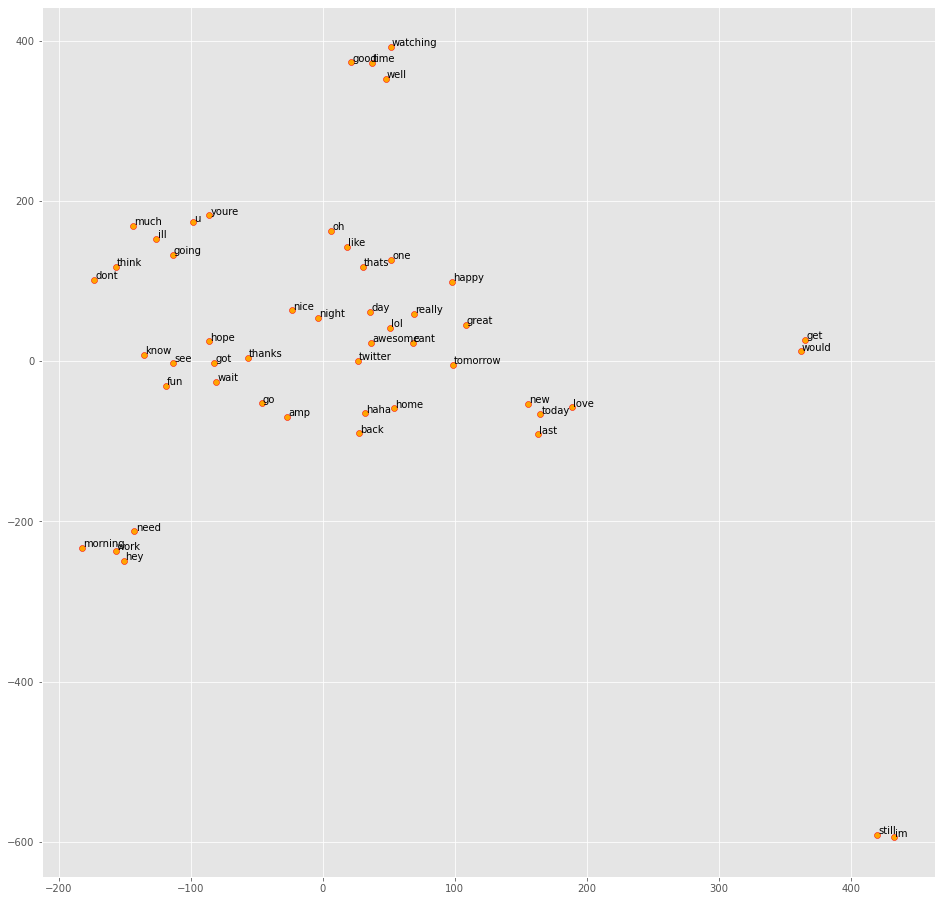

In [46]:
from sklearn.manifold import TSNE

fts = ft_model.wv[ft_model.wv.key_to_index] # Coordinates of the words

#fts = list(ft_model.wv.index_to_key)

tsne = TSNE(n_components=2, random_state=100, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(fts[350:400])
labels = list(ft_model.wv.index_to_key)

plt.figure(figsize=(16, 16))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

Las palabras cercanas tienen una alta similitud, en este caso, need, morning y work, tienen una alta similaridad, al igual que las palabras hope, thanks, fun, las cuales se encuentran muy cercanas en el plano.